# ライブラリ

In [39]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [38]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set() # グラフ描画用
from sklearn.metrics import classification_report

import pandas as pd

from pycm import ConfusionMatrix

import csv

import time
from datetime import datetime
import pytz

0.10.2.post1
2.2.2


# データセットの作成

In [41]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [40]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

## ラベルを含んだデータセット化

In [42]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [43]:
#object層
objLabel = [
    "y-shirt", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "alumi-rack", 
    
    "wood-desk", 
    "wood-shelf", 
    "floor", 
    
    "pla-Case", 
    "pla-Container", 
    "pla-Shelf"
]
objNum= []

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [44]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [45]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [46]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [47]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,5.976392,6.822977,4.681773,5.960326,6.270524,5.555223,6.263248,5.569991,4.882263,4.299622,5.108088,4.118065,4.122138,3.967569,4.116028,3.443338,3.565278,4.126280,3.916833,3.730920,3.637775,4.521054,4.199132,3.744049,3.643576,3.375568,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,7.861228,8.265740,4.599344,5.872322,4.592744,3.421162,4.752908,4.337614,6.370227,5.184047,4.849847,4.572804,3.635791,3.783034,3.855815,3.813673,3.487627,3.580301,3.614303,3.740953,3.072972,3.534535,3.042169,3.369778,3.774158,3.591752,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,6.910542,7.356769,5.536133,7.760330,7.464265,5.847036,6.778546,5.678427,4.762488,4.053427,6.746629,5.774625,3.554885,3.849524,4.361592,4.498605,3.461257,3.110470,3.792036,3.168753,3.338651,3.074583,3.769789,3.805089,3.840661,3.640197,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,5.838989,5.840345,5.350352,6.562118,6.123864,6.157910,7.798853,6.637695,6.310810,5.740537,4.283875,5.074739,3.838250,3.857526,3.533555,3.346363,3.364460,3.785767,3.506109,3.593435,4.064413,3.785521,3.418873,3.216819,3.263939,3.749777,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,5.856325,6.333907,5.194138,6.457110,4.888209,4.113900,5.447219,4.366963,3.742785,2.560735,5.125865,4.269754,3.551385,3.413525,3.984665,4.006360,3.462488,4.036200,4.038141,4.260864,3.809444,3.164510,3.141529,2.988619,3.524484,3.013673,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,5.124491,4.392790,1.810222,5.293355,5.642115,3.310058,4.430147,3.386137,1.379967,-0.666656,5.105537,4.917675,4.501484,4.042367,3.783863,3.439915,3.156824,3.767117,3.808424,2.824884,3.257201,3.367261,3.585934,3.489178,3.633662,3.934377,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,6.478649,5.214549,2.118699,5.707488,5.733986,4.036478,4.300111,2.886257,0.640900,-1.331358,4.723089,4.082846,4.431724,3.982713,3.259048,3.752981,3.357792,3.044743,3.499603,3.455720,3.645651,3.302137,3.499025,3.197227,3.511314,3.536093,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,6.095145,5.705307,3.509875,6.584274,7.103280,4.982163,5.235963,3.809655,0.283048,-1.342461,5.148210,5.663366,5.021627,4.321002,3.979507,3.939463,3.860337,3.043857,3.623130,3.147361,3.714255,3.324411,3.435385,3.464588,3.725068,3.644720,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,6.293356,4.448233,1.728071,5.413582,5.679895,3.039169,4.058166,4.360455,2.007196,0.376558,5.098722,4.160040,4.192483,4.390195,3.627769,3.345509,2.960834,3.753970,3.574879,3.692788,3.605611,3.609307,3.550105,3.601384,3.634692,3.832821,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [48]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)
print(Dataset_melspec.shape)
print(type(Dataset_melspec))

(1050, 1, 128, 130)
<class 'numpy.ndarray'>


### データ分割

In [49]:
# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature, eval_feature, train_labels, eval_labels = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.7
)

val_feature, test_feature, val_labels, test_labels = train_test_split(
    eval_feature, eval_labels, 
    stratify=eval_labels[:, 0], shuffle=True, random_state=0, train_size=0.5
)


In [50]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)



# 評価

## t-SNEで特徴量空間の可視化

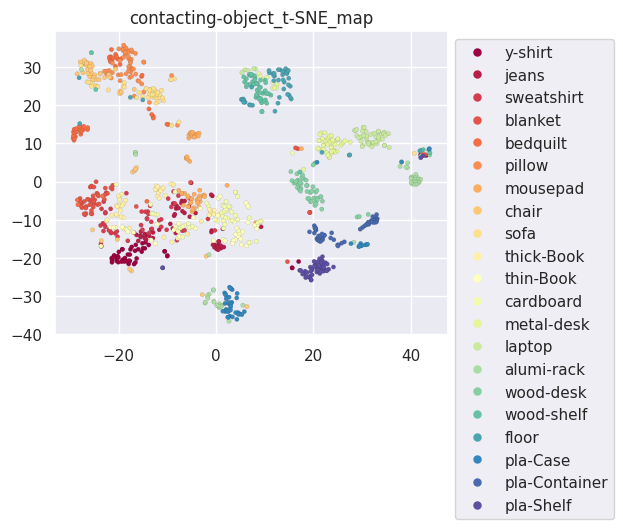

In [51]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [52]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


In [53]:
def Eval_svm_LOOO(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 21 #分割数
    stratifiedkfold = KFold(n_splits=folds, shuffle=False) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)

### object層

               precision    recall  f1-score   support

      y-shirt      0.896     0.860     0.878        50
        jeans      0.833     0.800     0.816        50
   sweatshirt      0.868     0.920     0.893        50
      blanket      0.644     0.760     0.697        50
     bedquilt      0.848     0.780     0.812        50
       pillow      0.809     0.760     0.784        50
     mousepad      0.712     0.740     0.725        50
        chair      1.000     0.960     0.980        50
         sofa      0.933     0.840     0.884        50
   thick-Book      0.741     0.860     0.796        50
    thin-Book      0.792     0.840     0.816        50
    cardboard      0.887     0.940     0.913        50
   metal-desk      0.980     0.980     0.980        50
       laptop      0.961     0.980     0.970        50
   alumi-rack      0.860     0.860     0.860        50
    wood-desk      0.654     0.680     0.667        50
   wood-shelf      0.933     0.840     0.884        50
        f

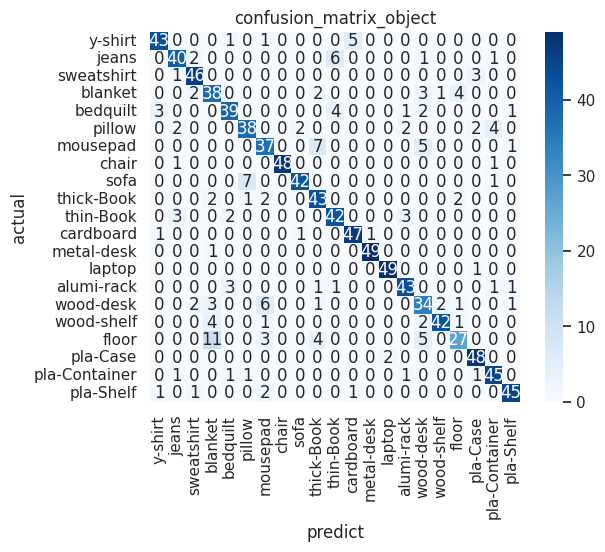

In [54]:
Eval_svm(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000      50.0
   sweatshirt      0.000     0.000     0.000      50.0
      blanket      0.000     0.000     0.000      50.0
     bedquilt      0.000     0.000     0.000      50.0
       pillow      0.000     0.000     0.000      50.0
     mousepad      0.000     0.000     0.000      50.0
        chair      0.000     0.000     0.000      50.0
         sofa      0.000     0.000     0.000      50.0
   thick-Book      0.000     0.000     0.000      50.0
    thin-Book      0.000     0.000     0.000      50.0
    cardboard      0.000     0.000     0.000      50.0
   metal-desk      0.000     0.000     0.000      50.0
       laptop      0.000     0.000     0.000      50.0
   alumi-rack      0.000     0.000     0.000      50.0
    wood-desk      0.000     0.000     0.000      50.0
   wood-shelf      0.000     0.000     0.000      50.0
        f

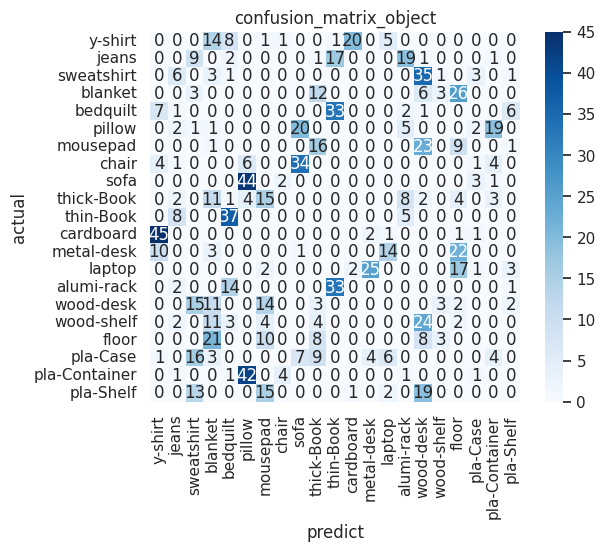

In [55]:
Eval_svm_LOOO(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

In [56]:
print( Dataset_mfcc.obj)

0         y-shirt
1         y-shirt
2         y-shirt
3         y-shirt
4         y-shirt
          ...    
1045    pla-Shelf
1046    pla-Shelf
1047    pla-Shelf
1048    pla-Shelf
1049    pla-Shelf
Name: obj, Length: 1050, dtype: object


### material層

              precision    recall  f1-score   support

    clothing      0.808     0.840     0.824       150
     bedding      0.787     0.887     0.834       150
 memory-foam      0.784     0.653     0.713       150
       paper      0.943     0.880     0.910       150
       metal      0.800     0.853     0.826       150
        wood      0.929     0.960     0.944       150
     plastic      0.910     0.880     0.895       150

    accuracy                          0.850      1050
   macro avg      0.852     0.850     0.849      1050
weighted avg      0.852     0.850     0.849      1050



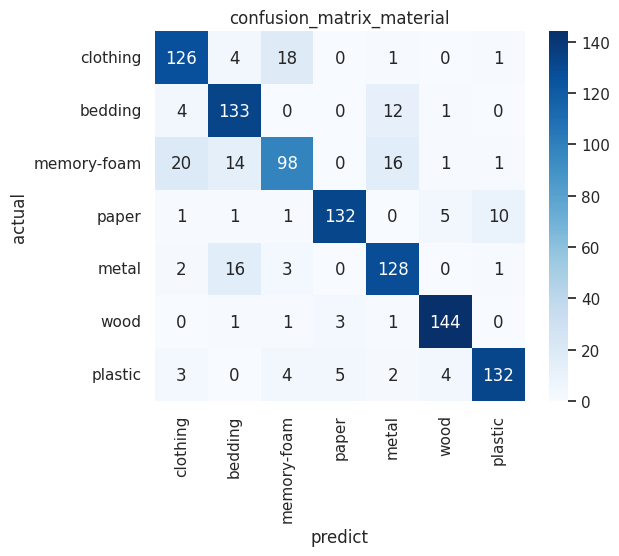

In [57]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

              precision    recall  f1-score   support

    clothing      0.209     0.193     0.201       150
     bedding      0.314     0.467     0.375       150
 memory-foam      0.110     0.113     0.112       150
       paper      0.400     0.333     0.364       150
       metal      0.381     0.500     0.432       150
        wood      0.460     0.267     0.338       150
     plastic      0.520     0.433     0.473       150

    accuracy                          0.330      1050
   macro avg      0.342     0.330     0.328      1050
weighted avg      0.342     0.330     0.328      1050



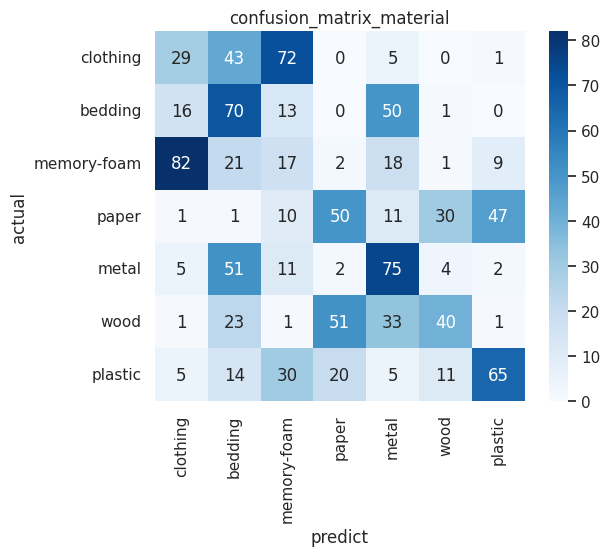

In [58]:
Eval_svm_LOOO(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

              precision    recall  f1-score   support

        soft      0.895     0.897     0.896       600
        hard      0.862     0.860     0.861       450

    accuracy                          0.881      1050
   macro avg      0.879     0.878     0.878      1050
weighted avg      0.881     0.881     0.881      1050



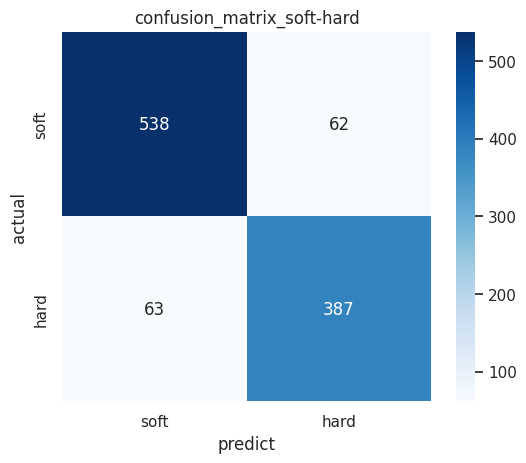

In [59]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

              precision    recall  f1-score   support

        soft      0.836     0.835     0.836       600
        hard      0.780     0.782     0.781       450

    accuracy                          0.812      1050
   macro avg      0.808     0.809     0.809      1050
weighted avg      0.812     0.812     0.812      1050



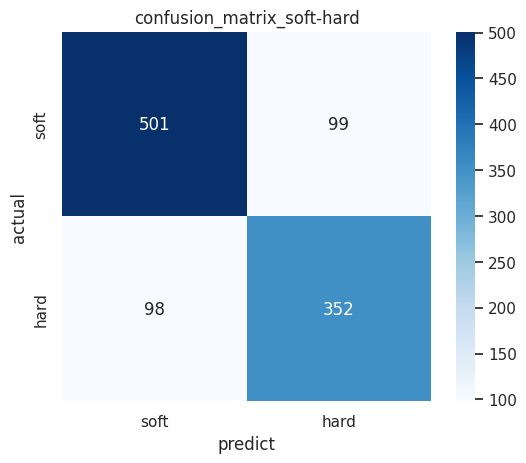

In [60]:
Eval_svm_LOOO(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

### 提案手法適用時の評価

In [61]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc = []
train_label_mfcc = []
eval_data_mfcc = []
eval_label_mfcc = []

train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)


In [62]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.objNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = objLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.objNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)

(420, 21)
420


In [63]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object


平均 decision: 0.5774906009018925
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         6
           1      1.000     1.000     1.000         2
           2      1.000     1.000     1.000         2
           3      1.000     1.000     1.000         5
           4      0.875     1.000     0.933         7
           5      1.000     1.000     1.000        11
           6      1.000     1.000     1.000         5
           7      0.857     1.000     0.923         6
           8      1.000     0.909     0.952        11
           9      1.000     1.000     1.000        11
          10      0.800     1.000     0.889         8
          11      1.000     0.500     0.667         4
          12      1.000     1.000     1.000         7
          13      1.000     0.846     0.917        13
          14      1.000     0.917     0.957        12
          15      1.000     1.000     1.000        16
          16      0.929     1.000     0.963      

In [64]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.matNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = matLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.matNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(420, 7)
420


,clothing,bedding,memory-foam,paper,metal,wood,plastic,decision,prediction,Actual
0,0.001182,0.027871,0.007272,0.000662,0.007784,0.954237,0.000991,0.954237,5,5
1,0.004041,0.142896,0.809251,0.015856,0.014720,0.012815,0.000420,0.809251,2,2
2,0.117623,0.008070,0.149368,0.670227,0.012502,0.032615,0.009594,0.670227,3,3
3,0.186709,0.035856,0.448443,0.229344,0.053502,0.026223,0.019924,0.448443,0,3
4,0.096941,0.010155,0.102019,0.672400,0.056712,0.019541,0.042231,0.672400,3,3
...,...,...,...,...,...,...,...,...,...,...
415,0.647091,0.007467,0.009982,0.324582,0.002542,0.000657,0.007679,0.647091,0,0
416,0.000961,0.008230,0.014657,0.002771,0.390736,0.581098,0.001548,0.581098,5,5
417,0.099218,0.803627,0.033132,0.014855,0.019822,0.020444,0.008901,0.803627,1,1
418,0.036472,0.026670,0.879254,0.010690,0.038796,0.003465,0.004653,0.879254,2,2


In [65]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)


平均 decision: 0.7695275889192149
              precision    recall  f1-score   support

           0      1.000     0.833     0.909        12
           1      0.714     0.833     0.769        12
           2      0.692     1.000     0.818         9
           3      0.875     1.000     0.933        14
           4      1.000     1.000     1.000         6
           5      1.000     0.714     0.833        14
           6      1.000     0.857     0.923        14

    accuracy                          0.877        81
   macro avg      0.897     0.891     0.884        81
weighted avg      0.902     0.877     0.879        81

採用数: 81
採用率: 0.19285714285714287
不採用: (156, 10)


In [66]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = shLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(420, 2)
420


,soft,hard,decision,prediction,Actual
0,0.159332,0.840668,0.840668,1,1
1,0.963539,0.036461,0.963539,0,0
2,0.197348,0.802652,0.802652,1,1
3,0.362554,0.637446,0.637446,1,1
4,0.097082,0.902918,0.902918,1,1
...,...,...,...,...,...
415,0.745264,0.254736,0.745264,0,0
416,0.035956,0.964044,0.964044,1,1
417,0.995630,0.004370,0.995630,0,0
418,0.815011,0.184989,0.815011,0,0


In [67]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
Up_softhard = df[df['decision'] >= average_decision_softhard]


print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)


平均 decision: 0.9082699757751251
              precision    recall  f1-score   support

           0      0.962     0.926     0.943        27
           1      0.949     0.974     0.961        38

    accuracy                          0.954        65
   macro avg      0.955     0.950     0.952        65
weighted avg      0.954     0.954     0.954        65

採用数: 65
採用率: 0.15476190476190477
不採用: (91, 5)


## CNNでの評価

### モデルの保存関数

In [68]:
def SaveModel(model,modelname):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')
    # 現在の日本時間を取得
    now = datetime.now(jst)
    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    model_path = 'data/models_saved/'+modelname+time+'.pth'
    torch.save(model, model_path)

# #読み込み用
# model_path = 'data/models_saved/shModel_1_202406281304.pth'
# xModel = torch.load(model_path)

### soft-hard 1

In [69]:

# # ラベルの指定
# t_df = Dataset.shNum

# # テンソル形式に変換
# df_tenosor = torch.tensor(Dataset_melspec, dtype=torch.float32)
# df_tenosor = torch.unsqueeze(df_tenosor, 1)
# label_tensor = torch.tensor(t_df, dtype=torch.int64)
# print(df_tenosor.size())

# # x と t を組み合わせて TensorDataset を作成
# dataset = torch.utils.data.TensorDataset(df_tenosor, label_tensor)

# # 各データセットのサンプル数を決定
# # train : val: test = 50%　: 25% : 25%
# n_train = int(len(dataset) * 0.5)
# n_val = int(len(dataset) * 0.25)
# n_test = len(dataset) - n_train - n_val
     
# # それぞれのサンプル数を確認
# print(n_train, n_val, n_test)

# # ランダムに分割を行うため、シードを固定して再現性を確保
# torch.manual_seed(0)

# # データセットの分割
# train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# # バッチサイズ
# batch_size = 25

      
# # shuffle はデフォルトで False のため、学習データのみ True に指定
# train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val, batch_size)
# test_loader = torch.utils.data.DataLoader(test, batch_size)

# print(train_loader)

# for batch in train_loader:
#     print(batch)

In [70]:
# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [71]:
# modelのインポート
from models.dymn.model import get_model as get_dymn
shModel = get_dymn(pretrained_name="dymn10_as")

#パラメータの更新を許可
for param in shModel.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
)
print(shModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [72]:
# # !pip install torchsummary
# import torchsummary

# summary = torchsummary.summary(model, (1, 128, 130))

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 10
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = shModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1
    
shModel_trained = net1
SaveModel(shModel_trained,"shModel_1")


cuda:0
Epoch [1/10], Train Loss: 2.6848, Validation Loss: 12.8453
Epoch [2/10], Train Loss: 1.3514, Validation Loss: 94.9189
Epoch [3/10], Train Loss: 0.6707, Validation Loss: 40.4532
Epoch [4/10], Train Loss: 0.2042, Validation Loss: 8.2903
Epoch [5/10], Train Loss: 0.1079, Validation Loss: 2.7729
Epoch [6/10], Train Loss: 0.0311, Validation Loss: 1.5175
Epoch [7/10], Train Loss: 0.0191, Validation Loss: 0.8425
Epoch [8/10], Train Loss: 0.0035, Validation Loss: 0.6801
Epoch [9/10], Train Loss: 0.0009, Validation Loss: 0.6142
Epoch [10/10], Train Loss: 0.0006, Validation Loss: 0.5328


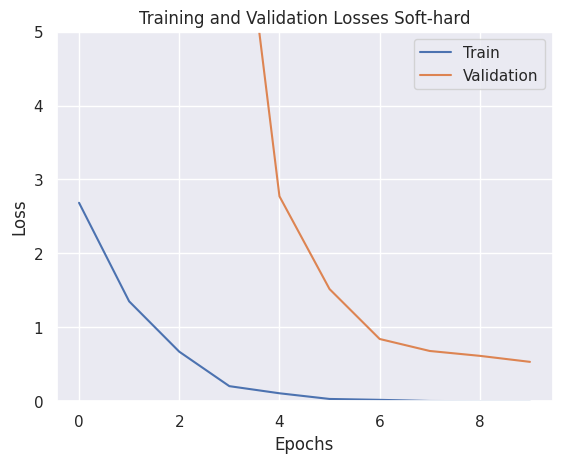

In [74]:
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [75]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 89.7%
Accuracy: 91.4%


tensor(0.9136)

### material 1

In [76]:
# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [77]:
matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_trained = net2
SaveModel(matModel_trained,"matModel_1")


cuda:0
Epoch [1/200], Train Loss: 1.9422, Validation Loss: 1.9371
Epoch [2/200], Train Loss: 1.9289, Validation Loss: 1.9252
Epoch [3/200], Train Loss: 1.9099, Validation Loss: 1.9048
Epoch [4/200], Train Loss: 1.8737, Validation Loss: 1.8643
Epoch [5/200], Train Loss: 1.7981, Validation Loss: 1.7771
Epoch [6/200], Train Loss: 1.6534, Validation Loss: 1.6389
Epoch [7/200], Train Loss: 1.4843, Validation Loss: 1.5316
Epoch [8/200], Train Loss: 1.3684, Validation Loss: 1.4827
Epoch [9/200], Train Loss: 1.3002, Validation Loss: 1.4563
Epoch [10/200], Train Loss: 1.2495, Validation Loss: 1.4338
Epoch [11/200], Train Loss: 1.1998, Validation Loss: 1.3969
Epoch [12/200], Train Loss: 1.1443, Validation Loss: 1.3602
Epoch [13/200], Train Loss: 1.0843, Validation Loss: 1.3213
Epoch [14/200], Train Loss: 1.0236, Validation Loss: 1.2832
Epoch [15/200], Train Loss: 0.9615, Validation Loss: 1.2641
Epoch [16/200], Train Loss: 0.8988, Validation Loss: 1.2457
Epoch [17/200], Train Loss: 0.8356, Valida

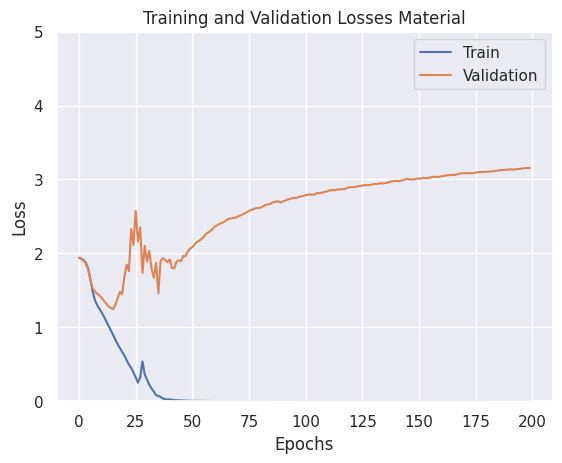

In [79]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [80]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 68.8%
Accuracy: 69.6%


tensor(0.6963)

### object 1

In [81]:
# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [82]:
objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')


objModel_trained = net3
SaveModel(objModel_trained,"objModel_1")

cuda:0
Epoch [1/150], Train Loss: 2.1418, Validation Loss: 2.4181
Epoch [2/150], Train Loss: 1.2769, Validation Loss: 2.0348
Epoch [3/150], Train Loss: 0.7597, Validation Loss: 2.2820
Epoch [4/150], Train Loss: 0.3825, Validation Loss: 1.3887
Epoch [5/150], Train Loss: 0.1713, Validation Loss: 1.1801
Epoch [6/150], Train Loss: 0.0831, Validation Loss: 1.0462
Epoch [7/150], Train Loss: 0.0321, Validation Loss: 1.0297
Epoch [8/150], Train Loss: 0.0165, Validation Loss: 1.0094
Epoch [9/150], Train Loss: 0.0117, Validation Loss: 0.9813
Epoch [10/150], Train Loss: 0.0093, Validation Loss: 0.9885
Epoch [11/150], Train Loss: 0.0077, Validation Loss: 0.9959
Epoch [12/150], Train Loss: 0.0065, Validation Loss: 0.9993
Epoch [13/150], Train Loss: 0.0059, Validation Loss: 0.9960
Epoch [14/150], Train Loss: 0.0053, Validation Loss: 0.9865
Epoch [15/150], Train Loss: 0.0046, Validation Loss: 0.9846
Epoch [16/150], Train Loss: 0.0043, Validation Loss: 0.9945
Epoch [17/150], Train Loss: 0.0039, Valida

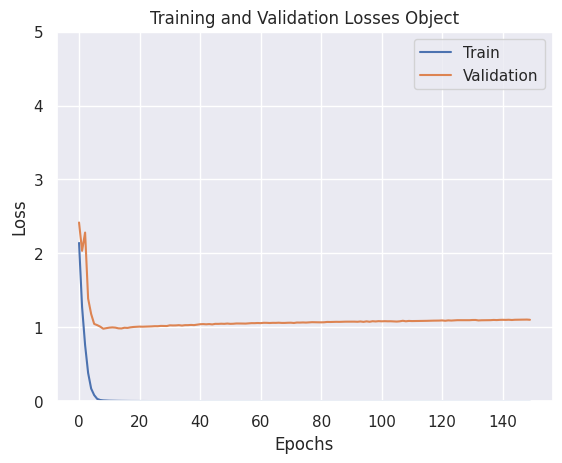

In [84]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Object'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [85]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 74.2%
Accuracy: 75.3%


tensor(0.7529)

### soft-hard 2

In [86]:
# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [87]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')

shModel_2_trained = net4
SaveModel(shModel_2_trained,"shModel_2")


cuda:0
Epoch [1/150], Train Loss: 0.6865, Validation Loss: 0.6689
Epoch [2/150], Train Loss: 0.6830, Validation Loss: 0.6639
Epoch [3/150], Train Loss: 0.6823, Validation Loss: 0.6618
Epoch [4/150], Train Loss: 0.6817, Validation Loss: 0.6606
Epoch [5/150], Train Loss: 0.6810, Validation Loss: 0.6596
Epoch [6/150], Train Loss: 0.6800, Validation Loss: 0.6584
Epoch [7/150], Train Loss: 0.6786, Validation Loss: 0.6569
Epoch [8/150], Train Loss: 0.6766, Validation Loss: 0.6544
Epoch [9/150], Train Loss: 0.6732, Validation Loss: 0.6503
Epoch [10/150], Train Loss: 0.6670, Validation Loss: 0.6425
Epoch [11/150], Train Loss: 0.6540, Validation Loss: 0.6249
Epoch [12/150], Train Loss: 0.6195, Validation Loss: 0.5742
Epoch [13/150], Train Loss: 0.5132, Validation Loss: 0.4306
Epoch [14/150], Train Loss: 0.2679, Validation Loss: 0.2835
Epoch [15/150], Train Loss: 0.0808, Validation Loss: 0.2955
Epoch [16/150], Train Loss: 0.0273, Validation Loss: 0.3362
Epoch [17/150], Train Loss: 0.0133, Valida

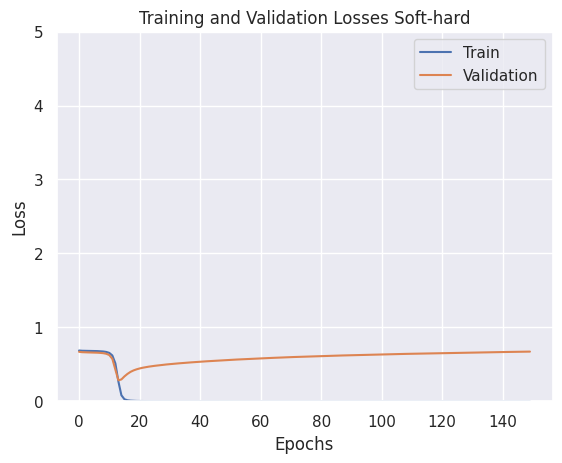

In [89]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Soft-hard'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,False)

In [90]:
# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)


Accuracy: 90.9%
Accuracy: 91.9%


tensor(0.9187)

### material 2

In [91]:
# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 100

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [92]:
matModel_2 = shModel_2_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_gred = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=False),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=88, out_features=7, bias=True),  # 新しい層  
)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
min_epoch = 100
max_epoch = 150     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
# for epoch in range(max_epoch):
train_epoch_loss = 1.0
val_epoch_loss = 1.0

while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.2) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

matModel_2_trained = net5
SaveModel(matModel_2_trained,"matModel_2")


cuda:0
Epoch [1/150], Train Loss: 0.8609, Validation Loss: 1.9180
Epoch [2/150], Train Loss: 0.2005, Validation Loss: 1.8744
Epoch [3/150], Train Loss: 0.1044, Validation Loss: 1.7905
Epoch [4/150], Train Loss: 0.0675, Validation Loss: 1.6340
Epoch [5/150], Train Loss: 0.0498, Validation Loss: 1.3889
Epoch [6/150], Train Loss: 0.0389, Validation Loss: 1.0611
Epoch [7/150], Train Loss: 0.0333, Validation Loss: 0.7937
Epoch [8/150], Train Loss: 0.0286, Validation Loss: 0.6532
Epoch [9/150], Train Loss: 0.0240, Validation Loss: 0.6437
Epoch [10/150], Train Loss: 0.0196, Validation Loss: 0.6711
Epoch [11/150], Train Loss: 0.0200, Validation Loss: 0.7021
Epoch [12/150], Train Loss: 0.0176, Validation Loss: 0.7296
Epoch [13/150], Train Loss: 0.0161, Validation Loss: 0.7486
Epoch [14/150], Train Loss: 0.0147, Validation Loss: 0.7590
Epoch [15/150], Train Loss: 0.0134, Validation Loss: 0.7711
Epoch [16/150], Train Loss: 0.0125, Validation Loss: 0.7778
Epoch [17/150], Train Loss: 0.0119, Valida

In [94]:
matModel_2_trained = net5


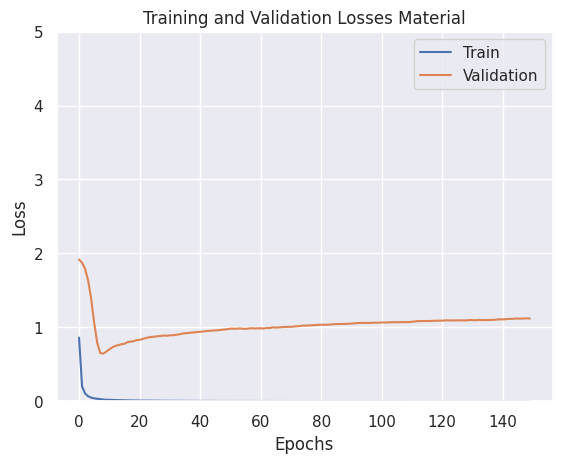

In [95]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [96]:

# dim=1 で行ごとの最大値に対する要素番号を取得（dim=0 は列ごと）
y_label = torch.argmax(y[0], dim=1)
# 予測値から最大となるクラスの番号を取り出した結果
y_label
# 目的変数
t
# 値が一致しているか確認
y_label == t
# int => float 
torch.sum(y_label == t) * 1.0
# 正解率
acc = torch.sum(y_label == t) * 1.0 / len(t)
acc


# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 80.6%
Accuracy: 81.9%


tensor(0.8188)

### object 2

In [97]:
# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 100

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[ -7.9676,  -6.4649,  -9.7551,  ..., -13.6345, -14.4751, -16.0697],
          [-10.1026,  -9.8093, -14.9717,  ..., -10.3715, -11.7278, -13.9461],
          [-17.6935, -21.1387, -24.1618,  ..., -20.3116, -22.9042, -19.6908],
          ...,
          [-58.0652, -55.9499, -56.4952,  ..., -55.8113, -55.1913, -56.1047],
          [-59.2388, -57.2715, -56.9817,  ..., -56.1107, -55.4308, -57.7903],
          [-58.6211, -55.5454, -55.7268,  ..., -56.3613, -55.6360, -57.5864]]],


        [[[-12.3534,  -8.1414,  -7.3962,  ...,  -9.6710, -10.2073, -18.5057],
          [-15.8491, -12.5674, -10.7024,  ..., -13.2207, -11.3987, -18.4529],
          [-24.6950, -25.3183, -25.8794,  ..., -25.2772, -20.0603, -21.6492],
          ...,
          [-58.5614, -54.2405, -53.9698,  ..., -55.7635, -55.6912, -56.3000],
          [-57.0635, -54.4432, -55.9435,  ..., -54.1819, -54.7409, -55.6478],
          [-57.2229, -55.7335, -56.3952,  ..., -56.5256, -54.9140, -55.9728]]],


        [[[ -9.2729,  -6.

In [98]:
objModel_2 = matModel_2_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad =  True # requires_gred -> requires_grad

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
)

print(objModel_2)


DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 1000     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.6) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

objModel_2_trained = net6
SaveModel(objModel_2_trained,"objModel_2")


cuda:0
Epoch [1/1000], Train Loss: 2.4483, Validation Loss: 3.0197
Epoch [2/1000], Train Loss: 1.6198, Validation Loss: 2.9701
Epoch [3/1000], Train Loss: 1.1866, Validation Loss: 2.8835
Epoch [4/1000], Train Loss: 0.8805, Validation Loss: 2.7312
Epoch [5/1000], Train Loss: 0.7016, Validation Loss: 2.4605
Epoch [6/1000], Train Loss: 0.5011, Validation Loss: 2.0560
Epoch [7/1000], Train Loss: 0.4086, Validation Loss: 1.6364
Epoch [8/1000], Train Loss: 0.3233, Validation Loss: 1.3150
Epoch [9/1000], Train Loss: 0.3147, Validation Loss: 1.1211
Epoch [10/1000], Train Loss: 0.2487, Validation Loss: 1.0402
Epoch [11/1000], Train Loss: 0.2196, Validation Loss: 1.0539
Epoch [12/1000], Train Loss: 0.1800, Validation Loss: 1.0638
Epoch [13/1000], Train Loss: 0.1679, Validation Loss: 1.0669
Epoch [14/1000], Train Loss: 0.1549, Validation Loss: 1.0231
Epoch [15/1000], Train Loss: 0.1270, Validation Loss: 0.9777
Epoch [16/1000], Train Loss: 0.1422, Validation Loss: 1.0228
Epoch [17/1000], Train Los

In [100]:
objModel_2_trained = net6


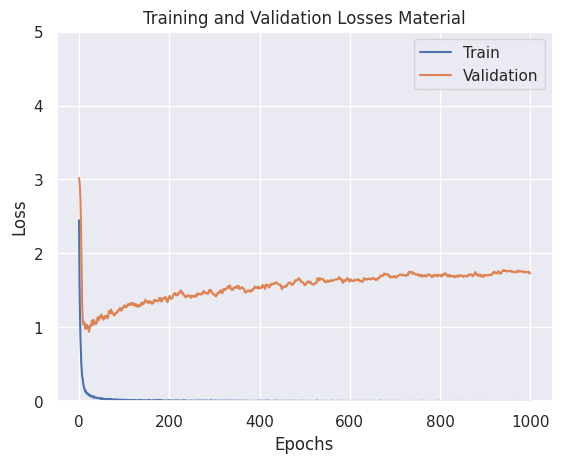

In [103]:
from datetime import datetime
import pytz
def ShowTrainLoss(train_losses,val_losses,save):
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')

    # 現在の日本時間を取得
    now = datetime.now(jst)

    # 時刻を指定された形式の文字列に変換
    time = "_"+now.strftime("%Y%m%d%H%M")

    # 学習曲線の可視化

    title = 'Training and Validation Losses Material'
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()
    if save == True:
        plt.savefig("data/"+title+time+".pdf")

    plt.show()

ShowTrainLoss(train_losses,val_losses,True)

In [104]:
# 正解率の計算
def calc_acc(data_loader):
    
    with torch.no_grad():
        
        accs = [] # 各バッチごとの結果格納用
        
        for batch in data_loader:
            x, t = batch
            
            # x = torch.unsqueeze(x,1)
            
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            
            y_label = torch.argmax(y[0], dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            accs.append(acc)
            
    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    
    return avg_acc
      
# 検証データで確認
calc_acc(val_loader)
# テストデータで確認
calc_acc(test_loader)

Accuracy: 74.6%
Accuracy: 76.7%


tensor(0.7666)